In [1]:
# import necessary modules

import torch
import torch.nn as nn
import torch.nn.functional as F

# load the mnist for autoencoder
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [2]:
x_train = torch.Tensor(x_train).reshape(-1, 784)/255
print(x_train.shape)

x_test = torch.Tensor(x_test).reshape(-1, 784)/255
print(x_test.shape)

#cut off abit of data to 1000 for RAM sake and efficiency purposes
x_train = x_train[0:1000]
print(x_train.shape)

torch.Size([60000, 784])
torch.Size([10000, 784])
torch.Size([1000, 784])


In [169]:
# Define custom Dense class in pytorch

class Dense(nn.Module):
    def __init__(self, I, O, f=F.elu):
        super().__init__()
        self.linear = torch.nn.Linear(I, O)
        self.f = f
    def forward(self, x):
        self.I = x
        self.Y = self.linear(x)
        self.Y.retain_grad() # Retain grads for penalty function
        
        
        self.O = self.f(self.Y)
        self.O.retain_grad() # Similar to above
        return self.O

In [235]:
# Build model

model = torch.nn.Sequential(
    Dense(784, 100, f=torch.relu),
    Dense(100, 28, f=torch.relu),
    Dense(28, 100, f=torch.relu),
    Dense(100, 784)
)

print(model)

Sequential(
  (0): Dense(
    (linear): Linear(in_features=784, out_features=100, bias=True)
  )
  (1): Dense(
    (linear): Linear(in_features=100, out_features=28, bias=True)
  )
  (2): Dense(
    (linear): Linear(in_features=28, out_features=100, bias=True)
  )
  (3): Dense(
    (linear): Linear(in_features=100, out_features=784, bias=True)
  )
)


In [119]:
# Define custom Loss function

class CustomLoss(nn.Module):
    def forward(self, pred, actual, a, b):
        # use MSELoss first to backpropagate loss gradients
        mse = F.mse_loss(pred, actual)
        mse.backward(create_graph=True)
        # mean-square all dmse/dO for all layers
        loss = 0
        for layer in model:
            if isinstance(loss, int):
                loss += torch.mean(layer.Y.grad**2).reshape(1,1)
            else:
                loss = torch.cat((loss, torch.mean(layer.Y.grad**2).reshape(1,-1)), dim=1)
        
        dev_loss = b * loss.std()
        '''loss = 0
        for layer in model:
            loss += torch.mean((layer.Y.grad)**2)'''
        model.zero_grad()
        return mse, a * loss.mean(), b * dev_loss

In [128]:
# test
loss_fn = CustomLoss()
pred = model(x_train)
mse, loss_mean, dev_loss = loss_fn(pred, x_train, 7e11,1e6) 
print(mse, loss_mean, dev_loss)

tensor(0.2324, grad_fn=<MseLossBackward0>) tensor(0.0525, grad_fn=<MulBackward0>) tensor(0.0524, grad_fn=<MulBackward0>)


In [240]:
# train the model with vanilla batch gradient descent first

lr = 1
loss_fn = nn.MSELoss()
for i in range(100):
    model.zero_grad()
    pred = model(x_train)
    loss = loss_fn(pred, x_train) 
    loss.backward()
    for p in model.parameters():
        p.data -= lr * p.grad
    print("Epoch: ", i, "MSE: ",loss)
    

Epoch:  0 MSE:  tensor(0.0627, grad_fn=<MseLossBackward0>)
Epoch:  1 MSE:  tensor(0.0627, grad_fn=<MseLossBackward0>)
Epoch:  2 MSE:  tensor(0.0627, grad_fn=<MseLossBackward0>)
Epoch:  3 MSE:  tensor(0.0627, grad_fn=<MseLossBackward0>)
Epoch:  4 MSE:  tensor(0.0627, grad_fn=<MseLossBackward0>)
Epoch:  5 MSE:  tensor(0.0627, grad_fn=<MseLossBackward0>)
Epoch:  6 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  7 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  8 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  9 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  10 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  11 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  12 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  13 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  14 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  15 MSE:  tensor(0.0626, grad_fn=<MseLossBackward0>)
Epoch:  16 MSE:  tensor(0.0626, grad_fn=<MseLossBa

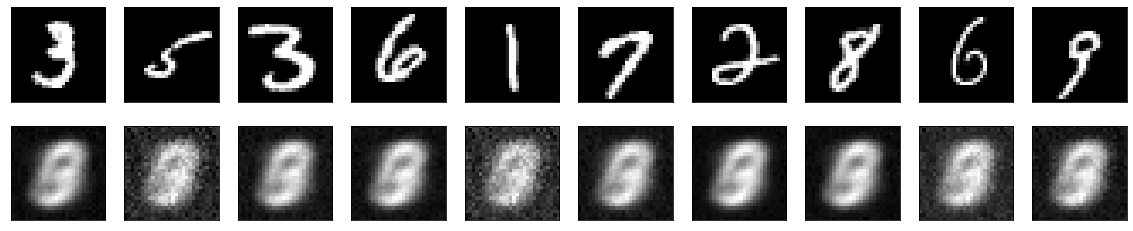

In [241]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
b = 10 # bth training sample to start from
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i+b].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(model(x_train[i+b]).detach().numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [139]:
lr = 0.1
a = 0.5
loss_fn = CustomLoss()
for i in range(1000):
    model.zero_grad()
    pred = model(x_train)
    mse, loss_mean, dev_loss = loss_fn(pred, x_train,7e11,1e6) 
    
    loss = mse + a*(loss_mean + dev_loss)/2
    loss.backward()
    for p in model.parameters():
        p.data -= lr * p.grad
    print("Epoch: ", i, "MSE: ",mse.item(), "Other: ", (a*(loss_mean+dev_loss)/2).item(),"Total Loss: ",loss.item())
    

Epoch:  0 MSE:  0.06441307812929153 Other:  0.0031482235062867403 Total Loss:  0.06756129860877991
Epoch:  1 MSE:  0.06441287696361542 Other:  0.003148189513012767 Total Loss:  0.0675610676407814
Epoch:  2 MSE:  0.06441264599561691 Other:  0.0031482477206736803 Total Loss:  0.06756089627742767
Epoch:  3 MSE:  0.06441247463226318 Other:  0.0031482060439884663 Total Loss:  0.06756068021059036
Epoch:  4 MSE:  0.06441228091716766 Other:  0.003148146905004978 Total Loss:  0.06756042689085007
Epoch:  5 MSE:  0.06441205739974976 Other:  0.003148202085867524 Total Loss:  0.06756026297807693
Epoch:  6 MSE:  0.06441187858581543 Other:  0.0031482710037380457 Total Loss:  0.06756015121936798
Epoch:  7 MSE:  0.06441168487071991 Other:  0.00314821838401258 Total Loss:  0.06755990535020828
Epoch:  8 MSE:  0.0644114539027214 Other:  0.003148272167891264 Total Loss:  0.06755972653627396
Epoch:  9 MSE:  0.06441128998994827 Other:  0.003148226533085108 Total Loss:  0.06755951792001724
Epoch:  10 MSE:  0.

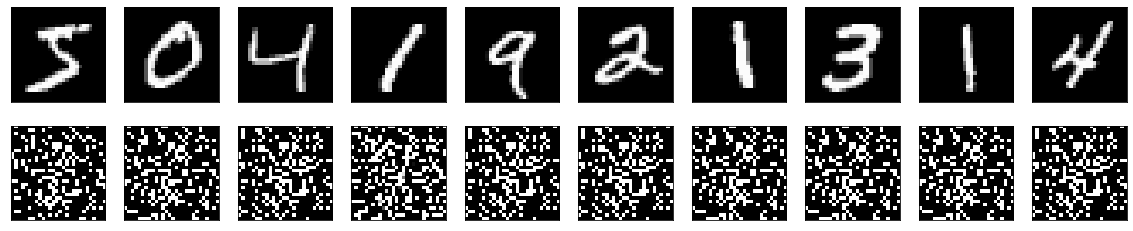

In [180]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
b = 0 # bth training sample to start from
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i+b].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(model(x_train[i+b]).detach().numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [247]:
# Explore gradients
torch.set_printoptions(threshold=1000)
Y = model[3].Y.grad.view(-1, 784, 1)
X = model[2].O.view(-1, 1, 100)
W = Y @ X
print(model[3].linear.weight.grad)

tensor([[ 3.0328e-07,  0.0000e+00, -1.9706e-09,  ...,  0.0000e+00,
          0.0000e+00,  1.1622e-06],
        [-4.1311e-07,  0.0000e+00,  8.1106e-09,  ...,  0.0000e+00,
          0.0000e+00, -2.1602e-06],
        [-9.5564e-08,  0.0000e+00,  5.7909e-09,  ...,  0.0000e+00,
          0.0000e+00, -1.0778e-07],
        ...,
        [ 7.0171e-08,  0.0000e+00, -4.9581e-09,  ...,  0.0000e+00,
          0.0000e+00,  2.7565e-07],
        [ 1.5770e-07,  0.0000e+00,  9.4372e-09,  ...,  0.0000e+00,
          0.0000e+00, -4.1393e-07],
        [-3.6309e-07,  0.0000e+00,  1.0169e-10,  ...,  0.0000e+00,
          0.0000e+00, -1.5692e-06]])


In [243]:
model.zero_grad()
pred = model(x_train[0:1000])
loss = loss_fn(pred, x_train[0:1000])
loss.backward()
print(loss)

tensor(0.0623, grad_fn=<MseLossBackward0>)
